In [ ]:
!pip -q install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00


1. Load a speech signal

In [ ]:
import torchaudio
import matplotlib.pyplot as plt
import torch

audio_path = "/content/Audio_Python.wav"
waveform, sr = torchaudio.load(audio_path)

print("Waveform shape:", waveform.shape)
print("Sampling rate:", sr)
print("Duration (sec):", waveform.shape[1] / sr)

2. Preprocess the audio (convert to mono, resample to 16kHz).

In [ ]:
import librosa
import numpy as np
import soundfile as sf

audio_path = "/content/Audio_Python.wav"

audio, sr = librosa.load(audio_path, sr=None, mono=True)

print("Before preprocessing:")
print("Sampling rate:", sr)
print("Duration (sec):", len(audio) / sr)

target_sr = 16000
if sr != target_sr:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    sr = target_sr

print("\nAfter preprocessing:")
print("Sampling rate:", sr)
print("Duration (sec):", len(audio) / sr)

output_path = "/content/Audio_Python_16kHz_mono.wav"
sf.write(output_path, audio, sr)

print("\n Saved preprocessed audio at:", output_path)

Before preprocessing:
Sampling rate: 16000
Duration (sec): 53.592

After preprocessing:
Sampling rate: 16000
Duration (sec): 53.592

 Saved preprocessed audio at: /content/Audio_Python_16kHz_mono.wav


3. Use a pre-trained deep learning model (Wav2Vec2) to recognize phonemes.

In [ ]:
!pip install -q phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 32.3 MB/s eta 0:00:00


In [ ]:
!pip -q install transformers g2p_en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import librosa
import nltk
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from g2p_en import G2p

nltk.download("punkt", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)
nltk.download("cmudict", quiet=True)

audio_path = "/content/Audio_Python_16kHz_mono.wav"
audio, sr = librosa.load(audio_path, sr=16000, mono=True)

assert sr == 16000, "Sampling rate must be 16kHz"

print("Expected outputs")
print("Loaded audio path:", audio_path)
print("Sampling rate:", sr)
print("Input audio samples:", len(audio))
print("Input duration (sec):", round(len(audio) / sr, 3))

model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print("\nModel loaded:", model_name)
print("Device:", device)

inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
input_values = inputs.input_values.to(device)

print("Model input tensor shape:", tuple(input_values.shape))

with torch.no_grad():
    logits = model(input_values).logits

print("Logits shape:", tuple(logits.shape))

pred_ids = torch.argmax(logits, dim=-1)
transcript = processor.batch_decode(pred_ids)[0].strip()

print("\nRecognized text (ASR output):")
print(transcript)

g2p = G2p()
phonemes = [p for p in g2p(transcript) if str(p).strip()]

print("\nRecognized phonemes (phoneme sequence):")
print(" ".join(phonemes))

print("\nRecognized phonemes (token list):")
print(phonemes)
print("Total phoneme tokens:", len(phonemes))

Expected outputs
Loaded audio path: /content/Audio_Python_16kHz_mono.wav
Sampling rate: 16000
Input audio samples: 857472
Input duration (sec): 53.592


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded: facebook/wav2vec2-base-960h
Device: cpu
Model input tensor shape: (1, 857472)
Logits shape: (1, 2679, 32)

Recognized text (ASR output):
METERTNI ATTRIBUTES RATER AS E CERRANKI OBJECNI FUNCTION LALA CALL CHERRANKI AGINAL FUNCTIONYOR GA MEDEDEDANI DRISOL CHERRANK EAGIAS ANIDI TAPUN GE DABLU E AGIAS AND EDI EDITIONARY GIL VALATITES BADLY LERO NAMO SIR NISTER FUNCTION YO ALL THE FUNCTION MADIEBUNI AS TE CHERDAM CORELBLDI MALU STATICAN A ISGOSOM STRIN ISH TWO MAESAN ANDIDIS RASIN GIVARTOM SIR CLATYOR CA MEVER YOU SES NI TATGINCERANKI IN THIRTIN DETSTO AT CESTNE APERNENLO AT CESTONY

Recognized phonemes (phoneme sequence):
M EH0 T ER0 T IY1 N IY0 AH0 T R IH1 B Y UW2 T S R EY1 T ER0 AE1 Z IY1 CH ER0 AA1 N S K IY0 AA0 B JH EH1 K N IY0 F AH1 NG K SH AH0 N L AA1 L AH0 K AO1 L CH ER0 AA1 N S K IY0 AE1 JH AH0 N AH0 L F AH1 NG K SH AH0 N IH1 R G AA1 M EH2 D EH0 D EH1 N IY0 D D R IH1 S AH0 L CH EH1 R AH0 NG K IY1 JH IY0 AH0 Z AH0 N IY1 D IY0 T AE1 P AH0 N JH IY1 D AE1 B L UW0 IY1 AA1

4. Estimate phoneme time intervals.

In [ ]:
duration_sec = len(audio) / sr
num_tokens = len(phonemes)

assert num_tokens > 0, "No phoneme tokens found. Run Step 3 again."

time_per_token = duration_sec / num_tokens

print("Expected outputs")
print("Total duration (sec):", round(duration_sec, 3))
print("Total phoneme tokens:", num_tokens)
print("Estimated time per token (sec):", round(time_per_token, 4))

phoneme_intervals = []
for i, ph in enumerate(phonemes):
    start_t = i * time_per_token
    end_t = (i + 1) * time_per_token
    phoneme_intervals.append((ph, start_t, end_t))

print("\nFirst 15 estimated phoneme time intervals (phoneme, start, end):")
for row in phoneme_intervals[:15]:
    ph, s, e = row
    print(ph, "|", round(s, 4), "to", round(e, 4))

print("\nLast 5 estimated phoneme time intervals (phoneme, start, end):")
for row in phoneme_intervals[-5:]:
    ph, s, e = row
    print(ph, "|", round(s, 4), "to", round(e, 4))

Expected outputs
Total duration (sec): 53.592
Total phoneme tokens: 342
Estimated time per token (sec): 0.1567

First 15 estimated phoneme time intervals (phoneme, start, end):
M | 0.0 to 0.1567
EH0 | 0.1567 to 0.3134
T | 0.3134 to 0.4701
ER0 | 0.4701 to 0.6268
T | 0.6268 to 0.7835
IY1 | 0.7835 to 0.9402
N | 0.9402 to 1.0969
IY0 | 1.0969 to 1.2536
AH0 | 1.2536 to 1.4103
T | 1.4103 to 1.567
R | 1.567 to 1.7237
IH1 | 1.7237 to 1.8804
B | 1.8804 to 2.0371
Y | 2.0371 to 2.1938
UW2 | 2.1938 to 2.3505

Last 5 estimated phoneme time intervals (phoneme, start, end):
S | 52.8085 to 52.9652
T | 52.9652 to 53.1219
AH0 | 53.1219 to 53.2786
N | 53.2786 to 53.4353
IY0 | 53.4353 to 53.592


5. Extract a phoneme segment from the speech signal based on time intervals.

In [ ]:
import numpy as np
import soundfile as sf

assert sr == 16000, "Sampling rate must be 16kHz"
assert len(phoneme_intervals) > 0, "phoneme_intervals is empty. Run Step 4."

target_index = 5

ph, start_t, end_t = phoneme_intervals[target_index]

start_sample = int(start_t * sr)
end_sample = int(end_t * sr)

start_sample = max(0, min(start_sample, len(audio) - 1))
end_sample = max(start_sample + 1, min(end_sample, len(audio)))

segment = audio[start_sample:end_sample]

out_path = f"/content/extracted_phoneme_{target_index}_{ph}.wav"
sf.write(out_path, segment, sr)

print("Expected outputs")
print("Selected phoneme index:", target_index)
print("Selected phoneme label:", ph)
print("Start time (sec):", round(start_t, 4))
print("End time (sec):", round(end_t, 4))
print("Start sample:", start_sample)
print("End sample:", end_sample)
print("Extracted segment samples:", len(segment))
print("Extracted segment duration (sec):", round(len(segment) / sr, 4))
print("Saved extracted phoneme to:", out_path)

Expected outputs
Selected phoneme index: 5
Selected phoneme label: IY1
Start time (sec): 0.7835
End time (sec): 0.9402
Start sample: 12536
End sample: 15043
Extracted segment samples: 2507
Extracted segment duration (sec): 0.1567
Saved extracted phoneme to: /content/extracted_phoneme_5_IY1.wav


6. Save extracted phoneme and visualize each selected phoneme segment from the speech waveform

Expected outputs
Total phoneme intervals: 342
Selected indices: [5, 10, 15]


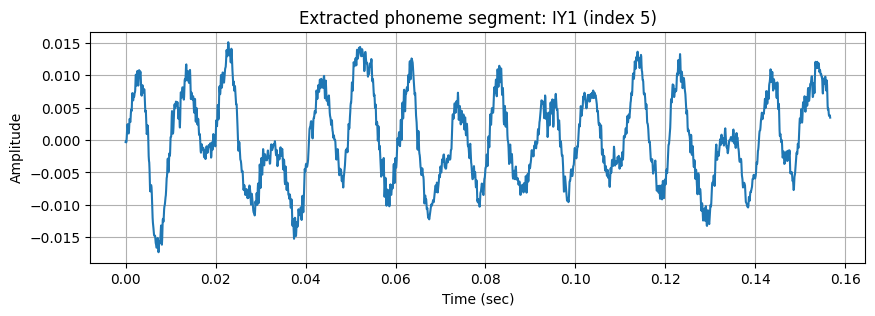


Segment output
Index: 5
Phoneme label: IY1
Start time (sec): 0.7835
End time (sec): 0.9402
Segment duration (sec): 0.1567
Saved file: /content/extracted_phoneme_5_IY1.wav


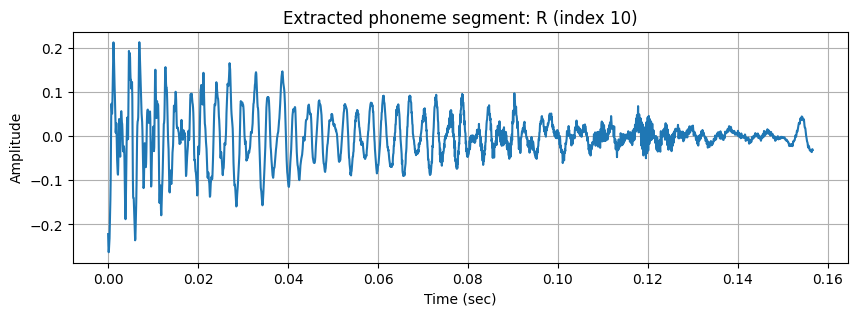


Segment output
Index: 10
Phoneme label: R
Start time (sec): 1.567
End time (sec): 1.7237
Segment duration (sec): 0.1567
Saved file: /content/extracted_phoneme_10_R.wav


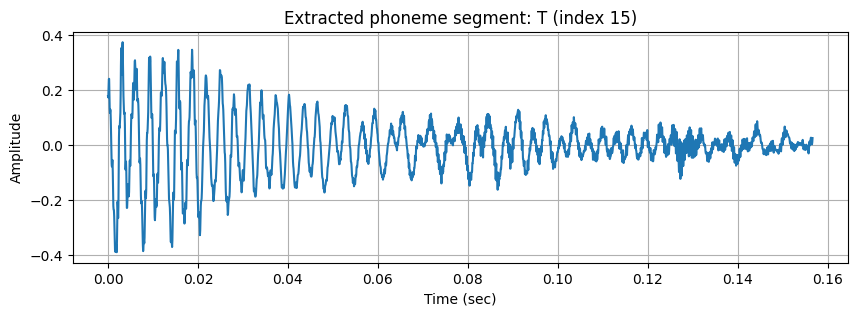


Segment output
Index: 15
Phoneme label: T
Start time (sec): 2.3505
End time (sec): 2.5072
Segment duration (sec): 0.1567
Saved file: /content/extracted_phoneme_15_T.wav


In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

assert sr == 16000, "Sampling rate must be 16kHz"
assert len(phoneme_intervals) > 0, "phoneme_intervals is empty. Run Step 4 first."

selected_indices = [5, 10, 15]

print("Expected outputs")
print("Total phoneme intervals:", len(phoneme_intervals))
print("Selected indices:", selected_indices)

for idx in selected_indices:
    if idx < 0 or idx >= len(phoneme_intervals):
        print(f"Skipping index {idx} (out of range)")
        continue

    ph, start_t, end_t = phoneme_intervals[idx]

    start_sample = int(start_t * sr)
    end_sample = int(end_t * sr)

    start_sample = max(0, min(start_sample, len(audio) - 1))
    end_sample = max(start_sample + 1, min(end_sample, len(audio)))

    segment = audio[start_sample:end_sample]

    out_path = f"/content/extracted_phoneme_{idx}_{ph}.wav"
    sf.write(out_path, segment, sr)

    seg_t = np.arange(len(segment)) / sr

    plt.figure(figsize=(10, 3))
    plt.plot(seg_t, segment)
    plt.title(f"Extracted phoneme segment: {ph} (index {idx})")
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    print("\nSegment output")
    print("Index:", idx)
    print("Phoneme label:", ph)
    print("Start time (sec):", round(start_t, 4))
    print("End time (sec):", round(end_t, 4))
    print("Segment duration (sec):", round(len(segment) / sr, 4))
    print("Saved file:", out_path)

7. Infer about the nature of source of sound for each phoneme.

In [ ]:
import numpy as np

assert sr == 16000, "Sampling rate must be 16kHz"
assert len(phoneme_intervals) > 0, "phoneme_intervals is empty. Run Step 4 first."

selected_indices = [5, 10, 15]

def zero_crossing_rate(x):
    if len(x) < 2:
        return 0.0
    return float(np.mean(x[:-1] * x[1:] < 0))

def rms_energy(x):
    if len(x) == 0:
        return 0.0
    return float(np.sqrt(np.mean(x ** 2)))

def is_vowel_like(phoneme_label):
    if len(phoneme_label) >= 2 and phoneme_label[-1].isdigit():
        return True
    vowel_set = {"AA","AE","AH","AO","AW","AY","EH","ER","EY","IH","IY","OW","OY","UH","UW"}
    return phoneme_label in vowel_set

print("Expected outputs")
print("Selected indices:", selected_indices)
print("For each selected phoneme: RMS energy, ZCR, voiced/unvoiced, phoneme-type inference\n")

for idx in selected_indices:
    if idx < 0 or idx >= len(phoneme_intervals):
        print(f"Skipping index {idx} (out of range)")
        continue

    ph, start_t, end_t = phoneme_intervals[idx]
    start_sample = int(start_t * sr)
    end_sample = int(end_t * sr)

    start_sample = max(0, min(start_sample, len(audio) - 1))
    end_sample = max(start_sample + 1, min(end_sample, len(audio)))

    segment = audio[start_sample:end_sample]

    seg_rms = rms_energy(segment)
    seg_zcr = zero_crossing_rate(segment)

    voiced_flag = seg_zcr < 0.12

    vowel_like = is_vowel_like(ph)

    if vowel_like and voiced_flag:
        source = "Voiced (likely vowel; periodic vocal-fold vibration)"
    elif (not vowel_like) and voiced_flag:
        source = "Voiced (likely voiced consonant/nasal/approximant)"
    elif (not vowel_like) and (not voiced_flag):
        source = "Unvoiced (likely fricative/stop; turbulent noise or burst)"
    else:
        source = "Mixed/uncertain (vowel-like label but unvoiced features; may be alignment/noise)"

    print("Phoneme index:", idx)
    print("Phoneme label:", ph)
    print("Time (sec):", round(start_t, 4), "to", round(end_t, 4))
    print("Segment duration (sec):", round(len(segment) / sr, 4))
    print("RMS energy:", round(seg_rms, 6))
    print("Zero Crossing Rate:", round(seg_zcr, 4))
    print("Voiced/Unvoiced (heuristic):", "Voiced" if voiced_flag else "Unvoiced")
    print("Vowel-like label:", "Yes" if vowel_like else "No")
    print("Inference:", source)
    print("-" * 60)


Expected outputs
Selected indices: [5, 10, 15]
For each selected phoneme: RMS energy, ZCR, voiced/unvoiced, phoneme-type inference

Phoneme index: 5
Phoneme label: IY1
Time (sec): 0.7835 to 0.9402
Segment duration (sec): 0.1567
RMS energy: 0.006893
Zero Crossing Rate: 0.0219
Voiced/Unvoiced (heuristic): Voiced
Vowel-like label: Yes
Inference: Voiced (likely vowel; periodic vocal-fold vibration)
------------------------------------------------------------
Phoneme index: 10
Phoneme label: R
Time (sec): 1.567 to 1.7237
Segment duration (sec): 0.1567
RMS energy: 0.053812
Zero Crossing Rate: 0.1165
Voiced/Unvoiced (heuristic): Voiced
Vowel-like label: No
Inference: Voiced (likely voiced consonant/nasal/approximant)
------------------------------------------------------------
Phoneme index: 15
Phoneme label: T
Time (sec): 2.3505 to 2.5072
Segment duration (sec): 0.1567
RMS energy: 0.103067
Zero Crossing Rate: 0.0998
Voiced/Unvoiced (heuristic): Voiced
Vowel-like label: No
Inference: Voiced (